In [28]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from collections import Counter
from env.area import Area

# Set seaborn theme globally
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)


def plot_histograms(projects, actions, area_pickle_file):
    contributors_per_project(projects)
    success_rate_over_time(projects)
    quality_metrics_over_time(projects)
    collab_metrics_over_time(projects)
    projects_per_contributor(projects)
    # prestige_per_project(projects)
    completion_per_project(projects)
    quality_per_project(projects)
    topic_area_per_project(projects, actions, area_pickle_file)

def build_reward_dataframe(reward_steps, agents):
    """
    Builds a DataFrame of accumulated rewards per agent per step,
    annotated with archetype.
    """
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            if v is not None:
                agent_archetype[k] = v["archetype"]

    records = []
    for step_idx, step in enumerate(reward_steps):
        for agent_id, data in step.items():
            if data is not None:
                data = data.get("observation", None)
                if data and "accumulated_rewards" in data:
                    archetype = agent_archetype.get(agent_id, None)
                    if archetype is not None:
                        records.append({
                            "step": step_idx,
                            "archetype": archetype,
                            "agent_id": agent_id,
                            "accumulated_rewards": data["accumulated_rewards"][0],
                            "h-index": data["peer_h_index"][0],
                            "age": data["age"][0]
                        })

    return pd.DataFrame(records)



def build_reward_summary_by_archetype(reward_steps, agents, seed, strategy):
    """
    Returns a DataFrame with rows:
      step, archetype, mean_reward, std_reward, n_agents, seed, strategy

    Raises:
        ValueError if any agent has no archetype mapping.
    """
    # === 1. Build agent_id -> archetype map ===
    agent_archetype = {}
    for a in agents:
        if not isinstance(a, dict):
            continue
        for agent_id, v in a.items():
            if v is None:
                continue
            if isinstance(v, dict) and "archetype" in v:
                agent_archetype[agent_id] = v["archetype"]

    if not agent_archetype:
        raise ValueError("No archetypes found in agents data.")

    # === 2. Build per-step stats grouped by archetype ===
    records = []
    for step_idx, step in enumerate(reward_steps):
        if not isinstance(step, dict):
            continue

        # Gather rewards per archetype for this step
        arch_rewards = {}
        for agent_id, data in step.items():
            if data is None:
                continue

            # Every agent MUST have an archetype
            if agent_id not in agent_archetype:
                raise ValueError(f"Missing archetype for agent_id '{agent_id}' at step {step_idx}")

            obs = data.get("observation", {}) if isinstance(data, dict) else {}
            if "accumulated_rewards" not in obs:
                continue

            reward = obs["accumulated_rewards"][0]
            archetype = agent_archetype[agent_id]
            arch_rewards.setdefault(archetype, []).append(reward)

        # Compute mean/std per archetype
        for archetype, rewards in arch_rewards.items():
            s = pd.Series(rewards)
            records.append({
                "step": step_idx,
                "archetype": archetype,
                "mean_reward": float(s.mean()),
                "std_reward": float(s.std(ddof=1)),  # sample std
                "n_agents": len(rewards),
                "seed": int(seed),
                "strategy": strategy,
            })

    return pd.DataFrame(records)


def societal_value_over_time(projects):
    # Convert to DataFrame
    df = pd.DataFrame(projects)

    # Sort by time
    df = df.sort_values("start_time")[df.start_time>100]

    # Compute cumulative sum and cumulative mean
    df["cumulative_societal_value"] = df["societal_value_score"].cumsum()
    df["cumulative_mean"] = df["cumulative_societal_value"] / (df.index + 1)

    # ==== Plot cumulative mean ====
    plt.figure(figsize=(8,6))
    plt.plot(df["start_time"], df["cumulative_mean"], linestyle="-", color="blue")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Mean Societal Value")
    plt.title("Cumulative Mean Societal Value Over Time")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def societal_value_per_archetype(agents, projects):
    # ==== Build agent → archetype map ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            idx = int(k.split('_')[1])   # extract numeric ID
            if v is not None:
                agent_archetype[idx] = v['archetype']
    # ==== Collect societal values per archetype ====
    records = []
    for p in projects:
        for contributor in p['contributors']:
            if contributor in agent_archetype:
                records.append({
                    'archetype': agent_archetype[contributor],
                    'societal_value': p['societal_value_score']
                })

    df = pd.DataFrame(records)
    # ==== Compute mean and error ====
    grouped = df.groupby("archetype")["societal_value"]
    means = grouped.mean()
    errors = grouped.std() / np.sqrt(grouped.count())  # Standard error of the mean
    # ==== Plot ====
    plt.figure(figsize=(8,6))
    means.plot(
        kind="bar",
        yerr=errors,
        capsize=5,
        color="skyblue",
        edgecolor="black"
    )
    plt.ylabel("Mean Societal Value (±SEM)")
    plt.title("Mean Societal Value per Archetype")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_reward_trajectories_subplots_stacked(dfs, save_path="reward_trajectories_stacked.png"):
    """
    Plot all agent reward trajectories (faint) + mean per archetype (bold)
    for multiple reward functions, stacked vertically.
    Only one shared legend, and saves the figure as a PNG.
    """
    n = len(dfs)
    fig, axes = plt.subplots(n, 1, figsize=(14, 5.5 * n), sharex=True, sharey=True)

    if n == 1:
        axes = [axes]

    for i, (ax, (name, df)) in enumerate(zip(axes, dfs.items())):
        # Faint individual trajectories
        sns.lineplot(
            data=df,
            x="step",
            y="accumulated_rewards",
            hue="archetype",
            units="agent_id",
            estimator=None,
            lw=0.8,
            alpha=0.1,
            ax=ax,
            legend=False
        )

        # Bold mean line per archetype
        sns.lineplot(
            data=df,
            x="step",
            y="accumulated_rewards",
            hue="archetype",
            estimator="mean",
            lw=2.5,
            ax=ax,
            legend=False
        )

        ax.set_title(name.replace("_", " ").title(), fontsize=16, pad=12)
        ax.set_xlabel("Time Step", fontsize=13)
        ax.set_ylabel("Accumulated Reward", fontsize=13)
        ax.grid(True, linestyle="--", alpha=0.6)

    # === Single shared legend ===
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Archetype",
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
        frameon=True,
        facecolor="white",
        framealpha=0.9
    )

    plt.suptitle("Accumulated Rewards Over Time by Reward Function", fontsize=18, y=0.995)
    plt.tight_layout(rect=[0, 0, 0.95, 0.97])

    # === Save to PNG ===
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✅ Figure saved to: {save_path}")

    plt.show()

def plot_reward_trajectories_subplots_side_by_side(dfs, save_path="reward_trajectories_side_by_side.png"):
    """
    Plot all agent reward trajectories (faint) + mean per archetype (bold)
    for multiple reward functions side by side.
    Uses one shared legend (from the first subplot) and saves as a high-res PNG.
    """
    n = len(dfs)
    fig, axes = plt.subplots(1, n, figsize=(7 * n, 6), sharey=True)
    variants = {"multiply": "conventional", "even": "fractional", "by_effort": "by effort"}

    if n == 1:
        axes = [axes]

    for i, (ax, (name, df)) in enumerate(zip(axes, dfs.items())):
        # Normalize accumulated rewards by the max per reward type
        df = df.copy()
        max_reward = df["accumulated_rewards"].max()
        if max_reward > 0:
            df["accumulated_rewards"] = df["accumulated_rewards"] / max_reward

        # Faint individual trajectories
        sns.lineplot(
            data=df,
            x="step",
            y="accumulated_rewards",
            hue="archetype",
            units="agent_id",
            estimator=None,
            lw=0.8,
            alpha=0.1,
            ax=ax,
            legend=False
        )

        # Bold mean line per archetype
        sns.lineplot(
            data=df,
            x="step",
            y="accumulated_rewards",
            hue="archetype",
            estimator="mean",
            lw=2.5,
            ax=ax,
            legend=(i == 0)
        )

        ax.set_title(variants[name].replace("_", " ").title(), fontsize=20, pad=12)
        ax.set_xlabel("Time Step", fontsize=16)
        if i == 0:
            ax.set_ylabel("Normalized Accumulated Reward", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.grid(True, linestyle="--", alpha=0.6)

    # === Extract legend from the first subplot ===
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend_.remove()  # remove local legend

    # === Add single shared legend ===
    fig.legend(
        handles,
        labels,
        title="Archetype",
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
        frameon=True,
        facecolor="white",
        framealpha=0.9
    )

    # plt.suptitle("Accumulated Rewards Over Time by Reward Function", fontsize=18, y=0.995)
    plt.tight_layout(rect=[0, 0, 0.95, 0.97])

    # === Save to PNG ===
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✅ Figure saved to: {save_path}")

    plt.show()


def plot_mean_reward_trajectories_subplots_side_by_side_individual_std(
    dfs,
    save_path="reward_trajectories_side_by_side.png",
    normalize=True,
):
    """
    Plot reward trajectories side by side for multiple reward functions.

    Shows:
      • Thin lines + shaded band = each seed's mean ± std (per archetype)
      • Bold line = mean across all seeds (per archetype, no shading)
      • Consistent colors across all subplots.

    Args:
        dfs (dict[str, pd.DataFrame]): mapping reward_name -> summary DataFrame with columns:
            ['step', 'archetype', 'mean_reward', 'std_reward', 'seed', 'strategy']
        save_path (str): output filename for figure
        normalize (bool): normalize rewards by max value per reward function
    """
    # Collect all archetypes to define a consistent color map
    all_archetypes = sorted({a for df in dfs.values() for a in df["archetype"].unique()})
    palette = sns.color_palette("tab10", len(all_archetypes))
    color_map = {a: palette[i] for i, a in enumerate(all_archetypes)}

    n = len(dfs)
    fig, axes = plt.subplots(1, n, figsize=(7 * n, 6), sharey=True)
    if n == 1:
        axes = [axes]

    for i, (ax, (name, df)) in enumerate(zip(axes, dfs.items())):
        df = df.copy()

        # Optional normalization (per reward function)
        if normalize:
            max_reward = df["mean_reward"].max()
            if max_reward > 0:
                df["mean_reward"] /= max_reward
                df["std_reward"] /= max_reward

        # --- Plot all seeds: mean ± std per seed ---
        for archetype, group_arch in df.groupby("archetype"):
            color = color_map[archetype]
            for seed, group_seed in group_arch.groupby("seed"):
                ax.plot(
                    group_seed["step"],
                    group_seed["mean_reward"],
                    lw=1.2,
                    alpha=0.5,
                    color=color,
                )
                ax.fill_between(
                    group_seed["step"],
                    group_seed["mean_reward"] - group_seed["std_reward"],
                    group_seed["mean_reward"] + group_seed["std_reward"],
                    color=color,
                    alpha=0.12,
                )

        # --- Compute mean across seeds (no shading) ---
        summary = (
            df.groupby(["step", "archetype"], as_index=False)
              .agg(mean_across_seeds=("mean_reward", "mean"))
        )

        # --- Plot bold average line (no shading) ---
        for archetype, group_arch in summary.groupby("archetype"):
            color = color_map[archetype]
            ax.plot(
                group_arch["step"],
                group_arch["mean_across_seeds"],
                lw=3,
                color=color,
                label=archetype,
            )

        # --- Format subplot ---
        ax.set_title(name.replace("_", " ").title(), fontsize=20, pad=12)
        ax.set_xlabel("Time Step", fontsize=16)
        if i == 0:
            ax.set_ylabel("Normalized Accumulated Reward" if normalize else "Accumulated Reward", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.grid(True, linestyle="--", alpha=0.6)

        if i == 0:
            ax.legend(title="Archetype", fontsize=12, title_fontsize=13)
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


def plot_mean_reward_trajectories_subplots_side_by_side(
    dfs,
    save_path="reward_trajectories_side_by_side.png",
    normalize=True,
):
    """
    Plot reward trajectories side by side for multiple reward functions.
    Shows:
      • Thin lines = each seed (per archetype)
      • Bold line + shaded band = mean ± std across seeds (per archetype)

    Args:
        dfs (dict[str, pd.DataFrame]): mapping reward_name -> summary DataFrame with columns:
            ['step', 'archetype', 'mean_reward', 'std_reward', 'seed', 'strategy']
        save_path (str): output filename for figure
        normalize (bool): if True, normalize mean_reward by max value per reward function
    """
    variants = {"multiply": "conventional", "even": "fractional", "by_effort": "by effort"}

    n = len(dfs)
    fig, axes = plt.subplots(1, n, figsize=(7 * n, 6), sharey=True)
    if n == 1:
        axes = [axes]

    palette = sns.color_palette("tab10")

    for i, (ax, (name, df)) in enumerate(zip(axes, dfs.items())):
        df = df.copy()

        # Optional normalization (per reward function)
        if normalize:
            max_reward = df["mean_reward"].max()
            if max_reward > 0:
                df["mean_reward"] /= max_reward
                df["std_reward"] /= max_reward

        # --- Plot all seeds (thin lines) ---
        for archetype_i, (archetype, group_arch) in enumerate(df.groupby("archetype")):
            color = palette[archetype_i % len(palette)]
            for seed, group_seed in group_arch.groupby("seed"):
                ax.plot(
                    group_seed["step"],
                    group_seed["mean_reward"],
                    lw=1,
                    alpha=0.35,
                    color=color,
                )

        # --- Compute mean ± std across seeds ---
        summary = (
            df.groupby(["step", "archetype"], as_index=False)
              .agg(mean_across_seeds=("mean_reward", "mean"),
                   std_across_seeds=("mean_reward", "std"))
        )

        # --- Plot bold mean line + shaded std per archetype ---
        for archetype_i, (archetype, group_arch) in enumerate(summary.groupby("archetype")):
            color = palette[archetype_i % len(palette)]
            ax.plot(
                group_arch["step"],
                group_arch["mean_across_seeds"],
                lw=3,
                color=color,
                label=archetype,
            )
            ax.fill_between(
                group_arch["step"],
                group_arch["mean_across_seeds"] - group_arch["std_across_seeds"],
                group_arch["mean_across_seeds"] + group_arch["std_across_seeds"],
                color=color,
                alpha=0.15,
            )

        # --- Format subplot ---
        ax.set_title(variants[name].replace("_", " ").title(), fontsize=20, pad=12)
        ax.set_xlabel("Time Step", fontsize=16)
        if i == 0:
            ax.set_ylabel("Normalized Accumulated Reward" if normalize else "Accumulated Reward", fontsize=16)
        else:
            ax.set_ylabel("")
        ax.grid(True, linestyle="--", alpha=0.6)

        # Legend: only on first subplot
        if i == 0:
            ax.legend(title="Archetype", fontsize=12, title_fontsize=13)
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

def visualize_total_rewards_over_time(simulation_steps, agents):
    """
    Visualize the average accumulated rewards per archetype over time.

    Args:
        simulation_steps (list): A list of dicts, where each dict represents a simulation step
                                 and maps agent IDs (e.g., 'agent_0') to their state dicts,
                                 which include 'accumulated_rewards'.
        agents (list): A list of agent dicts (e.g. [{'agent_0': {...}}, {'agent_1': {...}}])
                       containing each agent's archetype.
    """

    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # ==== 1. Build agent → archetype mapping ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            if v is not None and "archetype" in v:
                agent_archetype[k] = v["archetype"]
    # ==== 2. Collect records from all simulation steps ====
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent_id, data in step.items():
            if data is not None:
                data = data.get("observation", None)
                if "accumulated_rewards" in data:
                    archetype = agent_archetype.get(agent_id, None)
                    if archetype is not None:
                        records.append({
                            "step": step_idx,
                            "archetype": archetype,
                            "accumulated_rewards": data["accumulated_rewards"][0]
                        })
    df = pd.DataFrame(records)
    if df.empty:
        print("⚠️ No data available to plot (check input formats).")
        return

    # ==== 3. Compute mean reward per archetype per time step ====
    mean_rewards = (
        df.groupby(["step", "archetype"])["accumulated_rewards"]
        .mean()
        .reset_index()
        .sort_values("step")
    )

    # ==== 4. Plot ====
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=mean_rewards,
        x="step",
        y="accumulated_rewards",
        hue="archetype",
        linewidth=2.0
    )

    plt.title("Average Accumulated Rewards per Archetype Over Time")
    plt.xlabel("Simulation Step")
    plt.ylabel("Mean Accumulated Reward")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def visualize_cumulative_citations_over_time(projects, agents):
    """
    Visualize the mean number of cumulative citations per archetype over time.

    Each project contributes its citation count to *all* its contributors'
    archetypes (not just the dominant one).

    Args:
        projects (list): List of project dicts with keys:
                         - 'start_time': float or int
                         - 'citations': list of cited project IDs
                         - 'contributors': list of agent indices
        agents (list): List of agent dicts, e.g. [{'agent_0': {...}}, {'agent_1': {...}}]
                       Each agent dict must include an 'archetype' key.
    """

    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # ==== 1. Build agent → archetype mapping ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            if v is not None and "archetype" in v:
                agent_id = int(k.split("_")[1])
                agent_archetype[agent_id] = v["archetype"]

    # ==== 2. Collect project citation data for all contributors ====
    records = []
    for p in projects:
        citation_count = len(p.get("citations", []))
        for contributor in p.get("contributors", []):
            archetype = agent_archetype.get(contributor)
            if archetype:
                records.append({
                    "start_time": p["start_time"],
                    "archetype": archetype,
                    "citations": citation_count
                })

    df = pd.DataFrame(records)
    if df.empty:
        print("⚠️ No valid project or agent data to plot.")
        return

    # ==== 3. Sort and compute cumulative stats ====
    df = df.sort_values("start_time")

    cumulative_records = []
    for archetype, group in df.groupby("archetype"):
        group = group.sort_values("start_time")
        # cumulative sum of citations
        group["cumulative_citations"] = group["citations"].cumsum()
        # mean cumulative value (averaged across projects up to that point)
        group["mean_cumulative_citations"] = group["cumulative_citations"].expanding().mean()
        cumulative_records.append(group)

    cumulative_df = pd.concat(cumulative_records)

    # ==== 4. Plot ====
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=cumulative_df,
        x="start_time",
        y="mean_cumulative_citations",
        hue="archetype",
        linewidth=2.0
    )
    plt.ylim(bottom=1)
    plt.yscale("log")  # <-- add this line
    plt.title("Mean Cumulative Citations per Archetype Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Mean Cumulative Citations (log scale)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def contributors_per_project(projects):
    num_contributors = [len(p["contributors"]) for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(num_contributors, bins=range(1, max(num_contributors) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Contributors")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Contributors per Project")
    plt.tight_layout()
    plt.show()


def projects_per_contributor(projects):
    all_contributors = []
    for p in projects:
        all_contributors.extend(p["contributors"])

    author_counts = Counter(all_contributors)
    papers_per_author = list(author_counts.values())

    plt.figure(figsize=(8, 5))
    sns.histplot(papers_per_author, bins=range(1, max(papers_per_author) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Papers per Author")
    plt.ylabel("Number of Authors")
    plt.title("Authors by Number of Papers")
    plt.tight_layout()
    plt.show()


def prestige_per_project(projects):
    prestige_categories = [int(p["project_id"].split("-")[1]) % 3 for p in projects]

    plt.figure(figsize=(6, 4))
    sns.histplot(prestige_categories, bins=range(1, max(prestige_categories)), kde=False, discrete=True)
    plt.xlabel("Prestige Category (mod 3)")
    plt.ylabel("Number of Projects")
    plt.title("Projects per Prestige Category")
    plt.tight_layout()
    plt.show()


def completion_per_project(projects):
    completion = [max(0, p["current_effort"] / p["required_effort"]) * 100 for p in projects]
    plt.figure(figsize=(8, 5))
    sns.histplot(completion, bins=range(0, 110, 10), kde=False, discrete=True)
    plt.xlabel("Completion (%)")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Completion")
    plt.tight_layout()
    plt.show()


def quality_per_project(projects):
    quality_scores = [p["quality_score"] for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(quality_scores, bins=[i/10 for i in range(0, 11)], kde=False)
    plt.xlabel("Quality Score")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Quality Scores")
    plt.tight_layout()
    plt.show()

def success_rate_over_time(projects):
    """
    Plots the cumulative success rate of projects (finished / started)
    over time, using 'start_time' and 'finished' from the projects list.
    """
    # Extract (start_time, finished) for each project
    events = [(p["start_time"], p["finished"], p["final_reward"]) for p in projects]

    # Sort by start time
    events.sort(key=lambda x: x[0])

    time_steps = []
    success_rates = []

    finished = 0
    successful = 0

    for t, is_finished, score in events:
        if is_finished:
            finished += 1
            if score > 0:
                successful += 1
        success_rate = successful/ finished if finished > 0 else 0
        time_steps.append(t)
        success_rates.append(success_rate)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=time_steps, y=success_rates)
    plt.xlabel("Time Step")
    plt.ylabel("Success Rate")
    plt.title("Project Success Rate Over Time")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

def quality_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in one line plot.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]:[] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, p in projects_sorted]
    quality = [np.mean([p["quality_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    novelty = [np.mean([p["novelty_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    value = [np.mean([p["societal_value_score"] for p in pjs]) for _, pjs in projects_sorted]

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=times, y=quality, label="Quality Score")
    sns.lineplot(x=times, y=novelty, label="Novelty")
    sns.lineplot(x=times, y=value, label="Societal Value")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Project Metrics Over Time")
    plt.legend()
    # plt.tight_layout()
    plt.show()

def collab_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in three side-by-side plots.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]: [] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, _ in projects_sorted]
    effort = [np.mean([p["current_effort"] for p in pjs]) for _, pjs in projects_sorted]
    n_contributors = [np.mean([len(p["contributors"]) for p in pjs]) for _, pjs in projects_sorted]
    citations = [np.sum([len(p["citations"]) for p in pjs]) for _, pjs in projects_sorted]

    # Create 1 row, 3 column subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Plot effort
    sns.lineplot(x=times, y=effort, ax=axes[0])
    axes[0].set_title("Current Effort")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Effort")

    # Plot contributors
    sns.lineplot(x=times, y=n_contributors, ax=axes[1])
    axes[1].set_title("# Contributors per Paper")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("# Contributors")

    # Plot citations
    sns.lineplot(x=times, y=citations, ax=axes[2])
    axes[2].set_title("Citations")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Citations")

    plt.tight_layout()
    plt.show()



def topic_area_per_project(projects, actions, area_pickle_file):
    area = Area.load(area_pickle_file)
    papers = []
    agent_to_archetype = {}
    for step in actions:
        for agent, action in step.items():  # assume step is a list of agent dicts
            if action is not None and not agent in agent_to_archetype:
                agent_to_archetype[agent] = action["archetype"]
    for p in projects:
        main_archetype = Counter([agent_to_archetype[f"agent_{c}"] for c in p["contributors"]]).most_common(1)[0][0]
        papers.append((*p["kene"],main_archetype))
    area.visualize(sampled_points=papers)

def visualize_policy_population_proportion(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their proportions over time as a stacked area chart.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a list of agent dicts
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Normalize to proportions
    proportions = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot stacked area chart
    plt.figure()
    proportions.plot.area(colormap="tab20", alpha=0.85, figsize=(12, 8))

    plt.title("Archetype Proportions Over Simulation Steps")
    plt.xlabel("Step")
    plt.ylabel("Proportion")
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def visualize_policy_population(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their absolute counts over time as a line plot.
    Also shows the total number of agents per step in a smaller panel underneath.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a dict of agents
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Compute total per step
    total_counts = pivot.sum(axis=1)

    # Two subplots: main plot + smaller panel underneath
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Top: archetype counts
    pivot.plot.line(ax=axes[0])
    axes[0].set_title("Archetype Counts Over Simulation Steps")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Bottom: total counts
    total_counts.plot(ax=axes[1], color="black")
    axes[1].set_title("Total Agents")
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Total Count")

    plt.tight_layout()
    plt.show()

In [13]:
dfs = {
    "multiply": pd.read_parquet("results/reward_trajectories_multiply.parquet"),
    "even": pd.read_parquet("results/reward_trajectories_evenly.parquet"),
    "by_effort": pd.read_parquet("results/reward_trajectories_by_effort.parquet")
}

In [14]:
dfs["multiply"]

,step,archetype,agent_id,accumulated_rewards,h_index,age,seed
0,0,careerist,agent_0,0.000000,0,1,0
1,0,orthodox_scientist,agent_1,0.000000,0,1,0
2,0,orthodox_scientist,agent_2,0.000000,0,1,0
3,0,orthodox_scientist,agent_3,0.000000,0,1,0
4,0,mass_producer,agent_4,0.000000,0,1,0
...,...,...,...,...,...,...,...
1248243,599,orthodox_scientist,agent_1013,0.000000,0,25,9
1248244,599,mass_producer,agent_1017,2.551498,0,49,9
1248245,599,orthodox_scientist,agent_1019,0.000000,0,11,9
1248246,599,orthodox_scientist,agent_1033,0.000000,0,24,9


# Test for normality

In [15]:
from scipy.stats import normaltest

variants = {"multiply": "conventional", "even": "fractional", "by_effort": "by effort"}
archetypes = ["careerist", "orthodox_scientist", "mass_producer"]

for variant in variants:
    for archetype in archetypes:
        print(variant,":", archetype)
        df = dfs[variant][dfs[variant]['archetype'] == archetype]
        # print(df["step"].value_counts())
        stat, p = normaltest(df['accumulated_rewards'].values)
        print(f"Statistic={stat}, p-value={p}")

multiply : careerist
Statistic=212503.55289633607, p-value=0.0
multiply : orthodox_scientist
Statistic=199371.23186371793, p-value=0.0
multiply : mass_producer
Statistic=309415.5878629311, p-value=0.0
even : careerist
Statistic=187408.6803548938, p-value=0.0
even : orthodox_scientist
Statistic=190297.96324578839, p-value=0.0
even : mass_producer
Statistic=205091.70400927262, p-value=0.0
by_effort : careerist
Statistic=207145.4975491817, p-value=0.0
by_effort : orthodox_scientist
Statistic=170894.00436995173, p-value=0.0
by_effort : mass_producer
Statistic=268264.7339494014, p-value=0.0


# Test Significance between Reward Functions and Produce Figure

Processing Archetype: careerist...
conventional vs fractional: 0.838333
conventional vs by effort: 0.918333
fractional vs by effort: 0.006667
Processing Archetype: orthodox_scientist...
conventional vs fractional: 0.900000
conventional vs by effort: 0.965000
fractional vs by effort: 0.265000
Processing Archetype: mass_producer...
conventional vs fractional: 0.033333
conventional vs by effort: 0.000000
fractional vs by effort: 0.461667


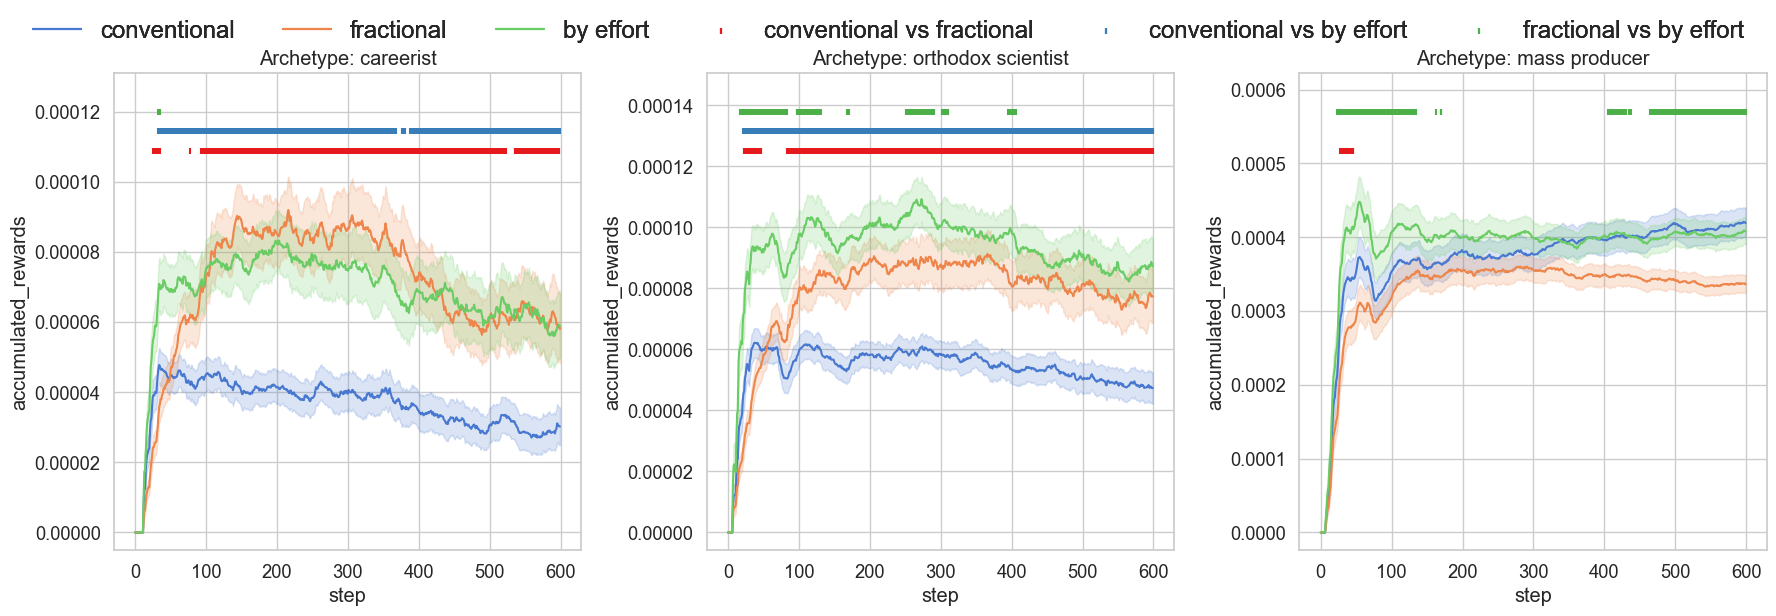

In [9]:

variants = {"multiply": "conventional", "even": "fractional", "by_effort": "by effort"}
archetypes = ["careerist", "orthodox_scientist", "mass_producer"]
# ==========================================
# 2. STATISTICAL ANALYSIS
# ==========================================

# 1. Identify unique time steps
time_steps = list(range(600))
pairs = list(combinations(variants, 2))
pair_colors = ['#e41a1c', '#377eb8', '#4daf4a'] # Red, Blue, Green for the 3 pairs
# Create a figure with 3 subplots (one for each archetype)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)


# ==========================================
# 2. MAIN LOOP (Stats + Plotting)
# ==========================================

for idx, arch in enumerate(archetypes):
    ax = axes[idx] # Select the current subplot
    print(f"Processing Archetype: {arch}...")

    # --- A. PREPARE DATA FOR PLOTTING ---
    # Combine the 3 variant dataframes for this specific archetype into one
    # This makes plotting with Seaborn much easier
    plot_data = []
    for v in variants:
        #normalize
        max_reward = dfs[v]["accumulated_rewards"].max()

        df_subset = dfs[v][dfs[v]['archetype'] == arch].copy()
        df_subset['variant'] = variants[v] # Label the variant
        if max_reward>0:
            df_subset["accumulated_rewards"] /= max_reward
            df_subset["accumulated_rewards"] /= (dfs[v]["age"]+1)
        
        
        plot_data.append(df_subset)
    
    combined_df = pd.concat(plot_data)    

    # --- B. PLOT PERFORMANCE CURVES ---
    sns.lineplot(
        data=combined_df, 
        x='step', 
        y='accumulated_rewards', 
        hue='variant', 
        ax=ax,
        errorbar=('ci'),
        n_boot=5000,
        seed=10,
        # errorbar=('se')
    )
    
    # --- C. STATISTICAL TESTS ---
    pairwise_results = {}
    
    for pair_idx, (distr1, distr2) in enumerate(pairs):
        raw_p_values = []
        
        # We assume time_steps are aligned. 
        # Optimized data retrieval:
        df1 = combined_df[(combined_df['archetype'] == arch) & (combined_df["variant"] == variants[distr1])]
        df2 = combined_df[(combined_df['archetype'] == arch) & (combined_df["variant"] == variants[distr2])]

        for t in time_steps:
            # Fast filtering
            d1 = df1[df1['step'] == t]['accumulated_rewards'].values
            d2 = df2[df2['step'] == t]['accumulated_rewards'].values
            
            # Check variance
            if len(d1) > 1 and len(d2) > 1 and not (np.all(d1 == d1[0]) and np.all(d2 == d2[0]) and d1[0] == d2[0]):
                try:
                    stat, p = stats.mannwhitneyu(d1, d2, alternative='two-sided')
                    raw_p_values.append(p)
                except ValueError:
                    raw_p_values.append(1.0)
            else:
                raw_p_values.append(1.0)

        # FDR Correction
        reject, pvals_corrected, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')
        
        # Store results and index for coloring
        pairwise_results[f"{variants[distr1]} vs {variants[distr2]}"] = (reject, pair_idx)
    for pairing in pairwise_results:
        proportion = np.sum(pairwise_results[pairing][0]) / len(pairwise_results[pairing][0])
        print(f"{pairing}: {proportion:2f}")

    # --- D. PLOT SIGNIFICANCE BARS ---
    # Calculate where to put the bars (above the highest data point)
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    current_height = y_max + (y_range * 0.02) # Start slightly above plot
    step_height = y_range * 0.05 # Distance between bars
    
    # Loop through results and plot markers
    for label, (is_sig, color_idx) in pairwise_results.items():
        sig_steps = np.array(time_steps)[is_sig]
        
        if len(sig_steps) > 0:
            # Plot horizontal line segments or markers
            ax.scatter(
                sig_steps, 
                [current_height] * len(sig_steps), 
                marker='|', 
                s=20, 
                color=pair_colors[color_idx], 
                label=label if idx == 0 else "" # Only add to legend on first plot
            )
        current_height += step_height

    # Final Styling
    ax.set_title(f"Archetype: {arch.replace('_', ' ')}")
    ax.set_ylim(y_min, current_height + step_height) # Expand limit to fit bars
    
    # Remove per-subplot legends entirely
    for ax in axes:
        leg = ax.get_legend()
        if leg:
            leg.remove()

    # Collect handles and labels from the first axis
    handles, labels = axes[0].get_legend_handles_labels()

    # Create a single, centered legend across the top
    fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),   # position above the subplots
        ncol=len(labels),             # spread across full width
        fontsize='large',
        frameon=False
    )


plt.tight_layout()
plt.show()

# Produce Lifespan Figure

Processing Archetype: careerist...
conventional vs fractional False 0.5919900610793659
conventional vs by effort False 0.5919900610793659
fractional vs by effort False 0.9872208372760163
Processing Archetype: orthodox_scientist...
conventional vs fractional False 0.8273725229140257
conventional vs by effort False 0.8273725229140257
fractional vs by effort False 0.8273725229140257
Processing Archetype: mass_producer...
conventional vs fractional False 0.841324544183165
conventional vs by effort False 0.841324544183165
fractional vs by effort False 0.841324544183165


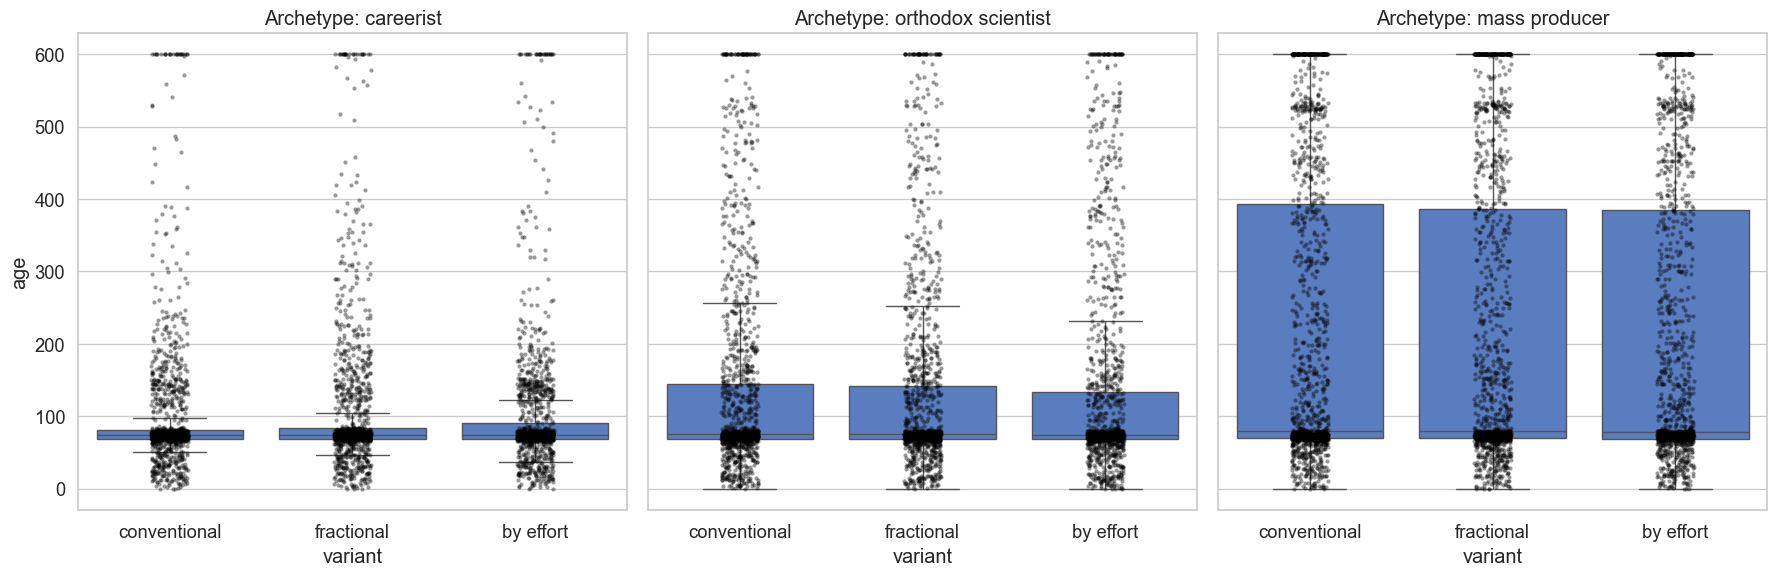

In [17]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

variants = {"multiply": "conventional", "even": "fractional", "by_effort": "by effort"}
archetypes = ["careerist", "orthodox_scientist", "mass_producer"]

pairs = list(combinations(variants, 2))
pair_colors = ['#e41a1c', '#377eb8', '#4daf4a']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, arch in enumerate(archetypes):
    ax = axes[idx]
    print(f"Processing Archetype: {arch}...")

    # =============================
    # A. BUILD MAX-AGE DATASET
    # =============================
    plot_rows = []

    for v in variants:
        df = dfs[v][dfs[v]["archetype"] == arch]

        # Compute max age per agent
        max_age = df.groupby("agent_id")["age"].max().reset_index()
        max_age["variant"] = variants[v]

        plot_rows.append(max_age)

    combined_df = pd.concat(plot_rows, ignore_index=True)

    # =============================
    # B. PLOT THE DISTRIBUTIONS
    # =============================
    sns.boxplot(
        data=combined_df,
        x="variant",
        y="age",
        ax=ax,
        showcaps=True,
        showfliers=False
    )

    sns.stripplot(
        data=combined_df,
        x="variant",
        y="age",
        ax=ax,
        color="black",
        size=3,
        alpha=0.4
    )

    # =============================
    # C. PAIRWISE STATISTICAL TESTS
    # =============================
    p_values = []
    labels = []
    pairwise_results = {}


    for pair_idx, (v1, v2) in enumerate(pairs):
        d1 = combined_df[combined_df["variant"] == variants[v1]]["age"].values
        d2 = combined_df[combined_df["variant"] == variants[v2]]["age"].values

        # Mann-Whitney U test
        stat, p = stats.mannwhitneyu(d1, d2, alternative="two-sided")

        p_values.append(p)
        labels.append(f"{variants[v1]} vs {variants[v2]}")

    # FDR correction
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    for l,r,p_val in zip(labels, reject, pvals_corrected):
        print(l, r, p_val)

    ax.set_title(f"Archetype: {arch.replace('_', ' ')}")

plt.tight_layout()
plt.show()


# Produce Trajectory Plots

In [18]:
dfs = {
    "multiply": pd.read_parquet("results/reward_summary_by_archetype_multiply.parquet"),
    "even": pd.read_parquet("results/reward_summary_by_archetype_evenly.parquet"),
    "by_effort": pd.read_parquet("results/reward_summary_by_archetype_by_effort.parquet")
}

In [19]:
from scipy.stats import shapiro
stat, p = shapiro(dfs["multiply"][dfs["multiply"]["step"]==200]["mean_reward"])
print("Shapiro:", stat, p)

Shapiro: 0.6871483152852775 1.0197746938504064e-06


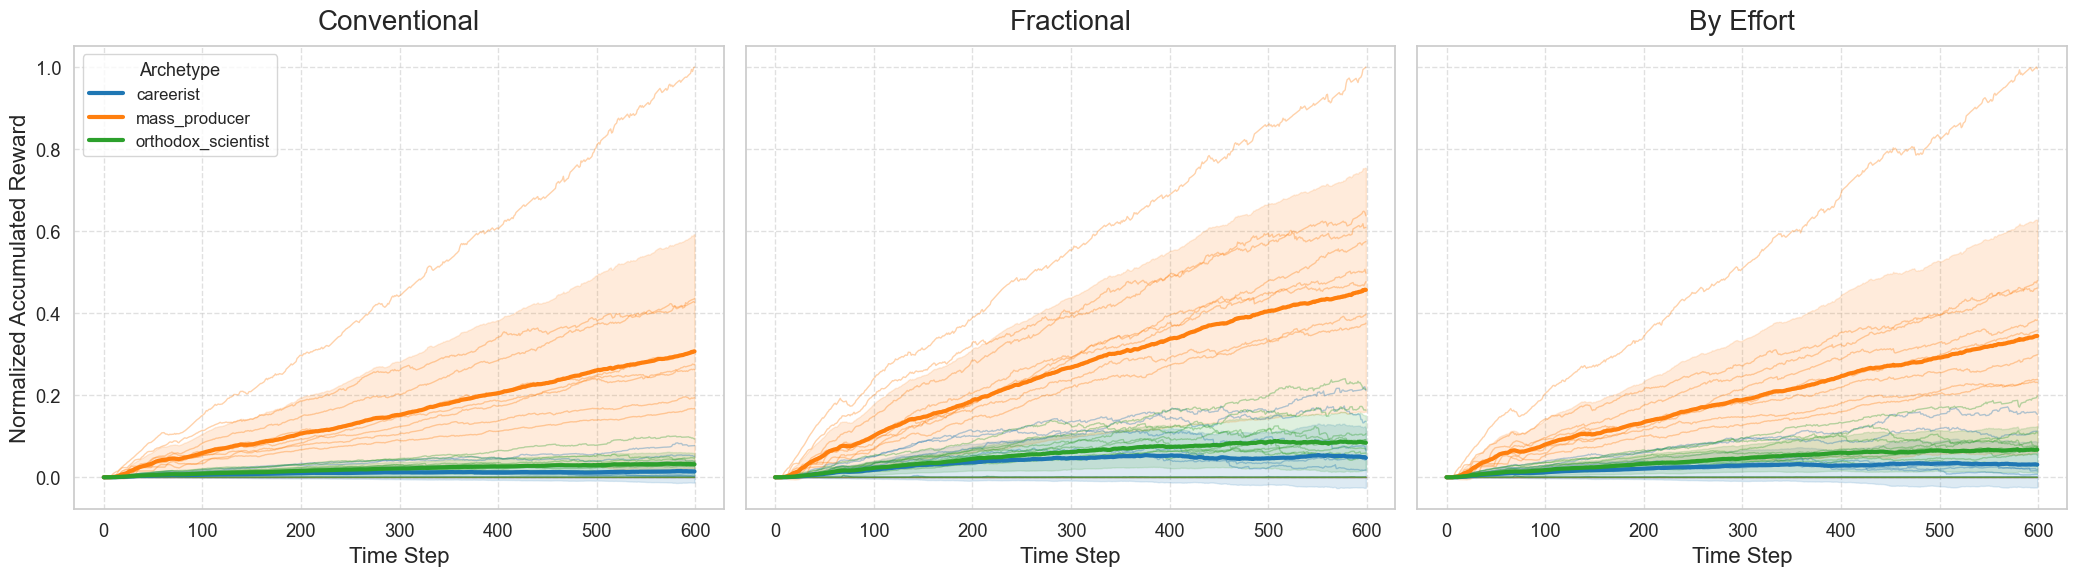

In [20]:
plot_mean_reward_trajectories_subplots_side_by_side(dfs)

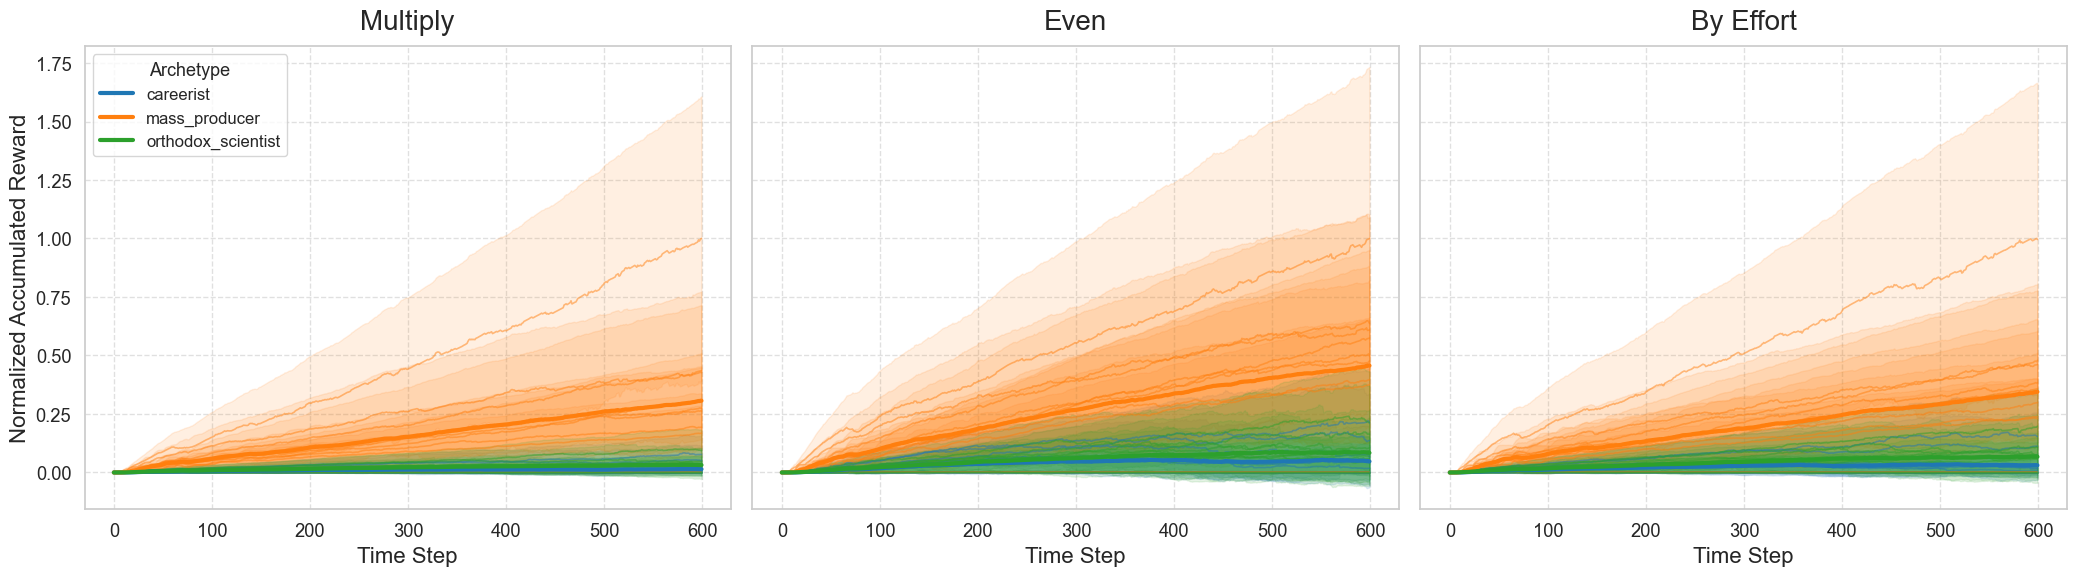

In [21]:
plot_mean_reward_trajectories_subplots_side_by_side_individual_std(dfs)

# Visualize Sensitivity Analysis

In [22]:
def plot_sobol_indices(json_files, output_labels, title="Sobol Sensitivity Indices"):
    """
    Plot S1 and ST Sobol sensitivity indices across multiple outputs.

    Parameters
    ----------
    json_files : list of str or Path
        Paths to JSON files containing 'S1' and 'ST' results.
    output_labels : list of str
        Names of output metrics (e.g., ["PPA", "APP", "CL", "PQ", "AR"]).
    title : str
        Plot title.
    """

    # Load all files
    sobol_data = []
    for f in json_files:
        with open(f, "r") as jf:
            sobol_data.append(json.load(jf))

    # Assume all have the same parameter order
    params = list(sobol_data[0]["S1"].keys())
    n_params = len(params)
    n_outputs = len(sobol_data)

    # Build matrices for S1 and ST
    S1 = np.zeros((n_params, n_outputs))
    ST = np.zeros((n_params, n_outputs))

    for j, data in enumerate(sobol_data):
        for i, p in enumerate(params):
            S1[i, j] = data["S1"][p]
            ST[i, j] = data["ST"][p]

    # Plot
    fig, axes = plt.subplots(1, n_outputs, figsize=(4 * n_outputs, 5), sharey=True)
    if n_outputs == 1:
        axes = [axes]

    for j, ax in enumerate(axes):
        x = np.arange(n_params)
        width = 0.35

        ax.bar(x - width/2, S1[:, j], width, label="$S_j$ (First-order)")
        ax.bar(x + width/2, ST[:, j], width, label="$S^T_j$ (Total-order)")

        ax.set_xticks(x)
        ax.set_xticklabels(params, rotation=45, ha="right")
        ax.set_title(output_labels[j])
        ax.grid(True, axis="y", linestyle="--", alpha=0.5)
        ax.set_ylim(bottom=min(np.min(S1), np.min(ST), -0.05))

    axes[0].set_ylabel("Sensitivity Index")
    fig.suptitle(title, fontsize=14)
    fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.05))
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

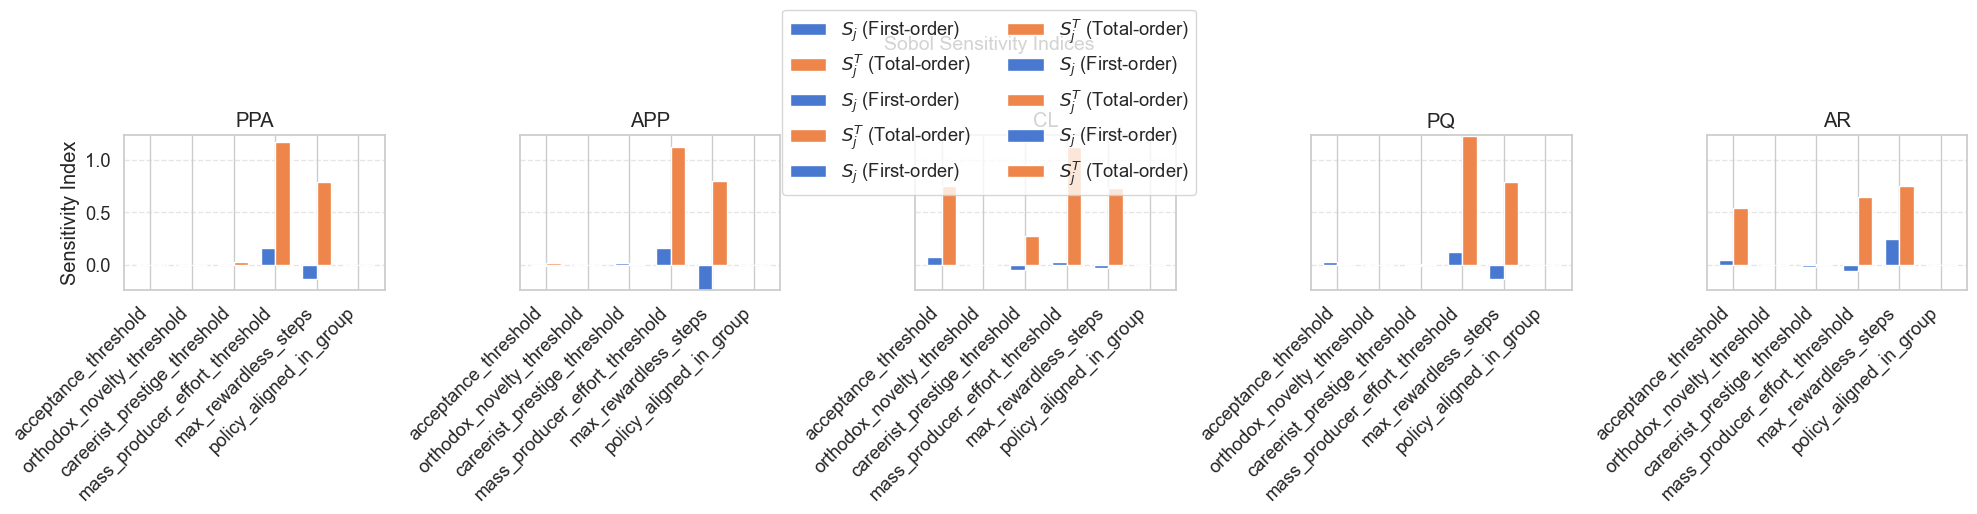

In [24]:
json_files = [
    "results/sensitivity_papers_per_author.json",
    "results/sensitivity_authors_per_paper.json",
    "results/sensitivity_lifespan.json",
    "results/sensitivity_quality.json",
    "results/sensitivity_acceptance.json",
]

output_labels = ["PPA", "APP", "CL", "PQ", "AR"]

plot_sobol_indices(json_files, output_labels)

In [11]:
with open("log/balanced_multiply_seed42_projects.json", "r") as f:
    balanced_multiply_projects = json.load(f)
with open("log/balanced_multiply_seed42_actions.jsonl", "r") as f:
    balanced_multiply_actions = []
    for line in f.readlines():
        balanced_multiply_actions.append(json.loads(line))
with open("log/balanced_multiply_seed42_observations.jsonl", "r") as f:
    balanced_multiply_observations = []
    for line in f.readlines():
        balanced_multiply_observations.append(json.loads(line))

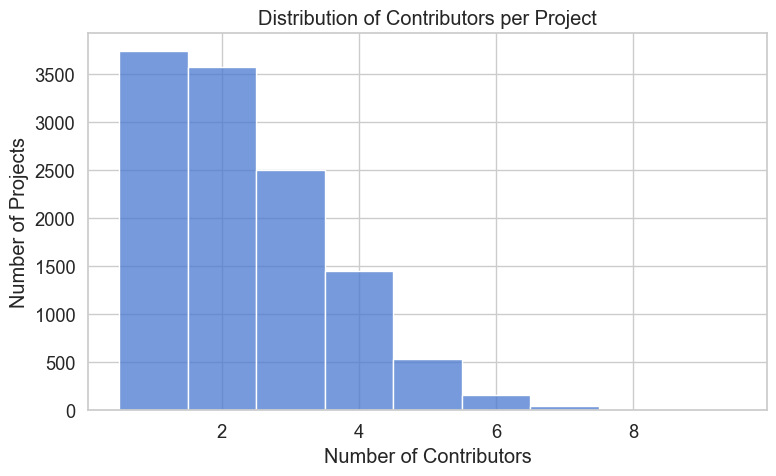

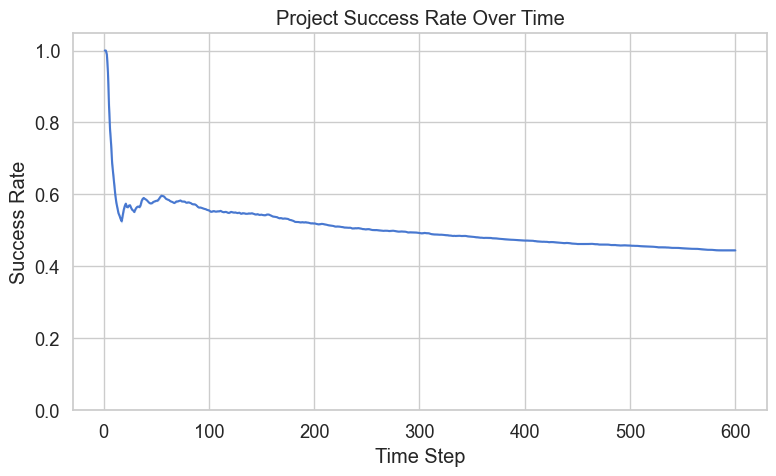

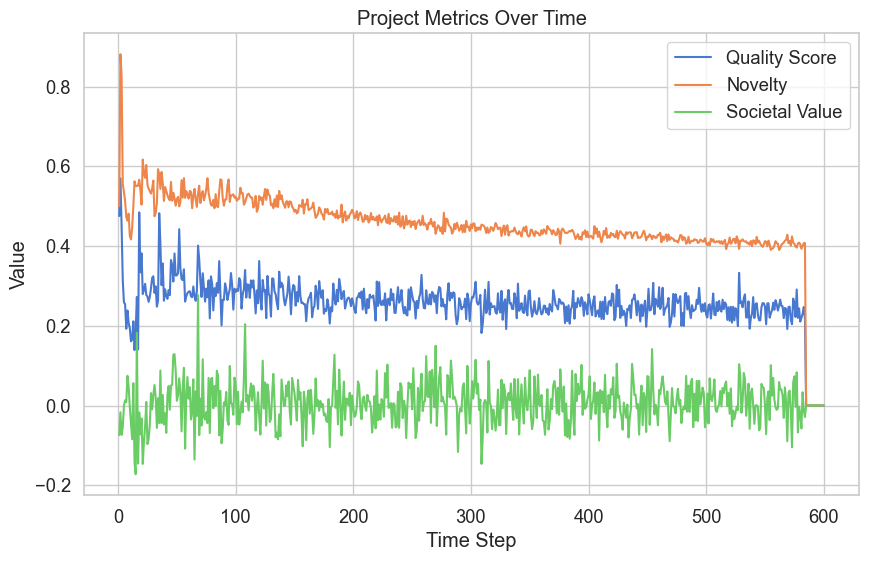

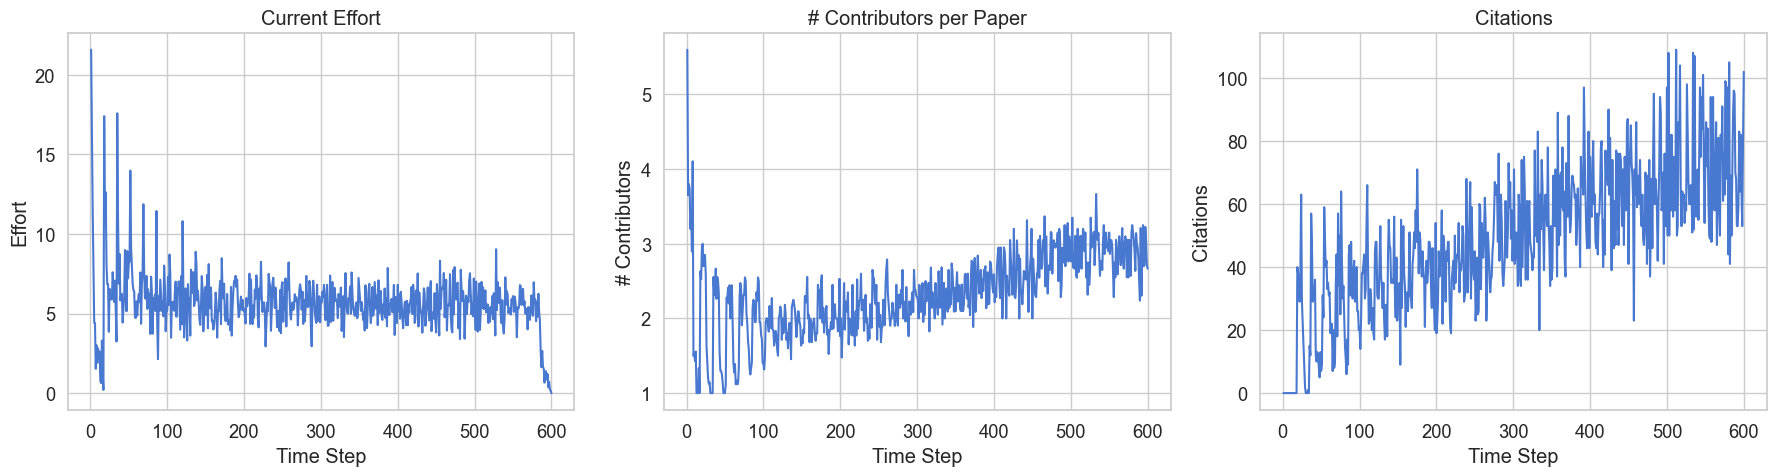

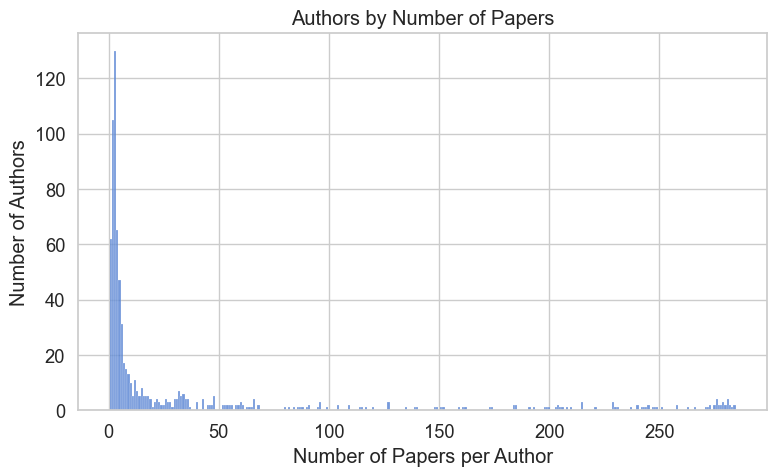

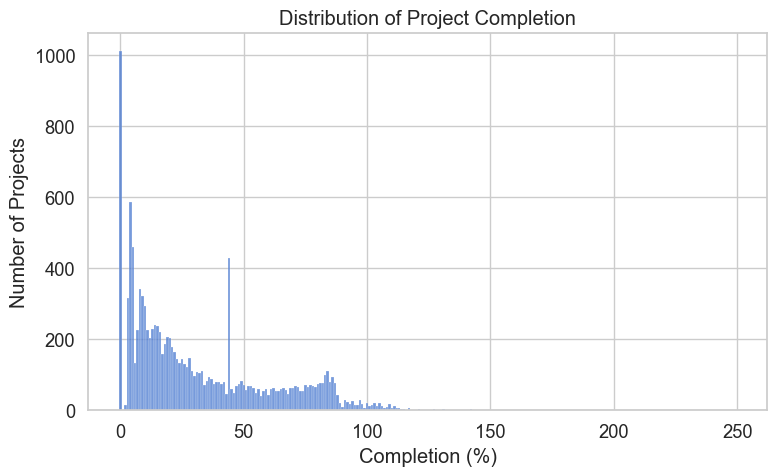

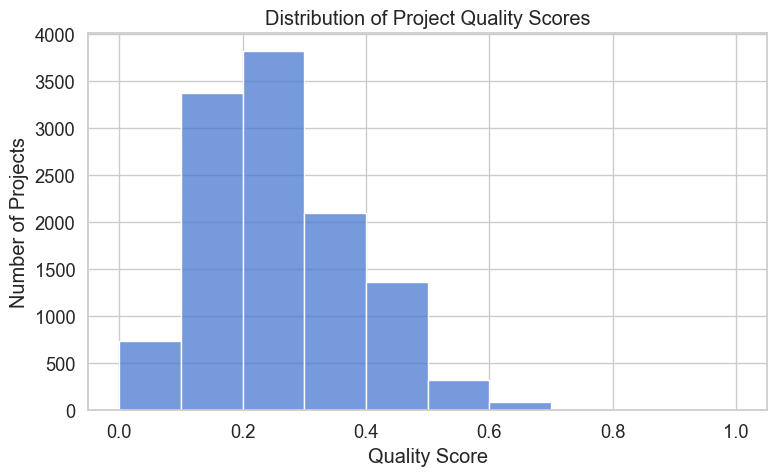

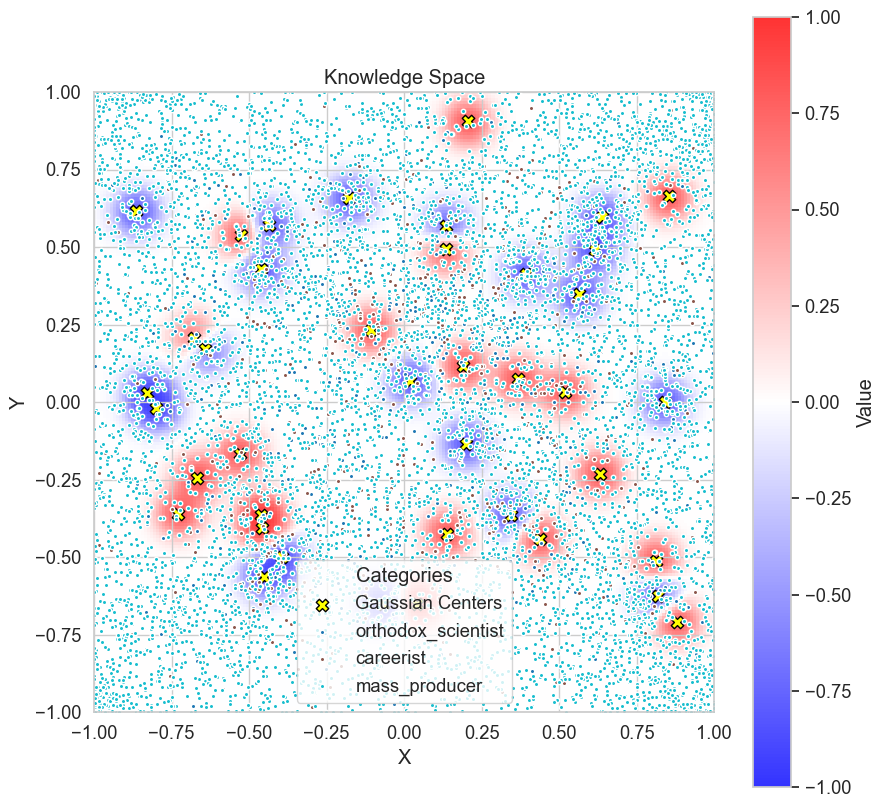

In [29]:
plot_histograms(balanced_multiply_projects, balanced_multiply_actions, "log/balanced_multiply_seed42_area.pickle")